In [1]:
# This get the RAPIDS-Colab install files and test check my GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 395 (delta 92), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (395/395), 108.50 KiB | 5.71 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.8 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!nvidia-smi

Wed Nov 22 18:47:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**TO ACCESS THE FILES AND FOLDERS FROM GOOGLE DRIVE**

In [23]:
#To access and store files on my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Install the necessary library
#!pip install gdown

# Define the file ID
file_id = '1RObmCDPeQ1Lg-V6u7dT02Pf0qH-QMcTp'

# Set the destination file path
destination_path = '/content/blur_dataset.zip.ext'

# Download the file
import gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination_path)

Downloading...
From: https://drive.google.com/uc?id=1RObmCDPeQ1Lg-V6u7dT02Pf0qH-QMcTp
To: /content/blur_dataset.zip.ext
100%|██████████| 5.02G/5.02G [00:34<00:00, 147MB/s]


'/content/blur_dataset.zip.ext'

In [27]:
import zipfile
# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/blur_dataset.zip.ext'
extraction_dir = '/content/blur_dataset'  # Change this to the desired extraction directory

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# **Required Data_Frame**

In [32]:
import cv2
import pandas as pd
import os
import cupy as cp
import matplotlib.pyplot as plt

# Define the directory containing the images
image_directory_blurred = '/content/blur_dataset/blur_dataset/defocused_blurred/'
image_directory_sharp = '/content/blur_dataset/blur_dataset/sharp/'

# Get a list of all files in the directory
image_files_blurred = os.listdir(image_directory_blurred)
image_files_sharp = os.listdir(image_directory_sharp)

# Create a DataFrame with image paths and add directory path to each file name
data0 = pd.DataFrame({'Image_Path': [image_directory_blurred + file for file in image_files_blurred]})
data1 = pd.DataFrame({'Image_Path': [image_directory_sharp + file for file in image_files_sharp]})

# Add a 'Target' column with a value of 0 for each image
data0['Target'] = 0
data1['Target'] = 1

# Display the DataFrame
print(data0.head())
print(data1.head())


# Concatenate the two DataFrames into a single DataFrame
data = pd.concat([data0, data1], ignore_index=True)

# Ground truth labels
ground_truth = data['Target'].tolist()


#data.info()

                                          Image_Path  Target
0  /content/blur_dataset/blur_dataset/defocused_b...       0
1  /content/blur_dataset/blur_dataset/defocused_b...       0
2  /content/blur_dataset/blur_dataset/defocused_b...       0
3  /content/blur_dataset/blur_dataset/defocused_b...       0
4  /content/blur_dataset/blur_dataset/defocused_b...       0
                                          Image_Path  Target
0  /content/blur_dataset/blur_dataset/sharp/48_HO...       1
1  /content/blur_dataset/blur_dataset/sharp/41_XI...       1
2  /content/blur_dataset/blur_dataset/sharp/216_A...       1
3  /content/blur_dataset/blur_dataset/sharp/312_A...       1
4  /content/blur_dataset/blur_dataset/sharp/304_S...       1


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cupyx.scipy.fftpack as cufft
import numpy as np

# Shuffle the data
data_shuffled = data.sample(frac=1, random_state=42)  # Shuffle the data

# Select a subset of the shuffled data
subset_size = 350
subset_data = data_shuffled.head(subset_size)
# Convert to 'data' is in DataFrame
image_path_list =subset_data['Image_Path'].tolist()
Ground_truth = subset_data['Target'].tolist()

# Load images into NumPy arrays
images = np.asarray([cp.asnumpy(cp.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE), dtype=cp.uint8)) for path in image_path_list])


<ipython-input-33-d11fb6280e3b>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray([cp.asnumpy(cp.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE), dtype=cp.uint8)) for path in image_path_list])


In [34]:
images

array([array([[239, 239, 239, ..., 103,  94,  94],
              [236, 237, 238, ..., 101,  96,  94],
              [235, 236, 237, ...,  99,  98,  93],
              ...,
              [ 87,  82,  75, ...,  66,  65,  60],
              [ 86,  78,  70, ...,  65,  64,  57],
              [ 83,  76,  70, ...,  62,  63,  59]], dtype=uint8),
       array([[130, 126, 129, ...,  64,  46,  46],
              [132, 126, 126, ...,  58,  42,  47],
              [126, 128, 127, ...,  57,  49,  54],
              ...,
              [ 31,  36,  37, ...,  83,  85,  86],
              [ 36,  40,  48, ...,  72,  80,  83],
              [ 35,  45,  63, ...,  64,  75,  82]], dtype=uint8),
       array([[136, 134, 132, ..., 139, 139, 139],
              [136, 136, 135, ..., 140, 139, 137],
              [138, 137, 135, ..., 137, 137, 137],
              ...,
              [153, 150, 151, ..., 158, 157, 155],
              [154, 150, 149, ..., 157, 157, 156],
              [160, 154, 153, ..., 156, 155, 1

**JUST FOR SEE THE MAGNITUDE SPECTRUM**

# **FFT ALGORITHM**

In [37]:
# Define GPU-accelerated FFT function
def detect_blur_fft_gpu(image_gpu, size=60, vis = False):
    (h, w) = image_gpu.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))

    # Perform FFT on the GPU
    fft = cufft.fft2(cp.asarray(image_gpu))

    # shift the low frequency component to the center
    fftShift = cp.fft.fftshift(fft)

    if vis:
        magnitude = 20 * cp.log(cp.abs(fftShift))
        (fig, ax) = plt.subplots(1, 2)
        ax[0].imshow(cp.asnumpy(image_gpu), cmap="gray")
        ax[0].set_title("Input")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(cp.asnumpy(magnitude), cmap="gray")
        ax[1].set_title("Magnitude Spectrum")
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        plt.show()

    fftShift[h // 2 - size:h // 2 + size, w // 2 - size:w // 2 + size] = 0
    fftShift = cp.fft.ifftshift(fftShift)
    recon = cp.fft.ifft2(fftShift)

    mean = cp.mean(20 * cp.log(cp.abs(recon)))

    return mean

# Extract features using GPU-accelerated FFT
features = cp.array([detect_blur_fft_gpu(image) for image in images])

# Split the data into training and testing sets
features_train, features_test, Ground_truth_train, Ground_truth_test = train_test_split(
    features.get(), subset_data['Target'], test_size=0.2, random_state=42
)

**Using Machine Learning Model**

In [38]:
#using Logistic Regression from scikit-learn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
P=model.fit(features_train.reshape(-1,1), Ground_truth_train)

In [40]:
# Assuming your data is stored in a DataFrame or Series named 'data'
Ground_truth_test_list=Ground_truth_test.tolist()


# **PERFORMANCE**

In [52]:
# Evaluate the model on the testing set
predictions = P.predict(features_test.reshape(-1,1))

#calculate the performance of the model
TP=0
TN=0
FN=0
FP=0

for i in range (len(Ground_truth_test)):
  if(Ground_truth_test_list[i]==1 and predictions[i]==1):
    TP+=1
  elif(Ground_truth_test_list[i]==0 and predictions[i]==0):
    TN+=1
  elif(Ground_truth_test_list[i]==1 and predictions[i]==0):
    FN+=1
  elif(Ground_truth_test_list[i]==0 and predictions[i]==1):
    FP+=1
print('True_positive=',TP)
print('True_negative=',TN)
print('False_negative=',FN)
print('False_positive=',FP)

Accuracy=(TP+TN)/(TP+TN+FP+FN)
print('Accuracy of the model is=',Accuracy)


True_positive= 25
True_negative= 36
False_negative= 4
False_positive= 5
Accuracy of the model is= 0.8714285714285714


# **OUT PUT**

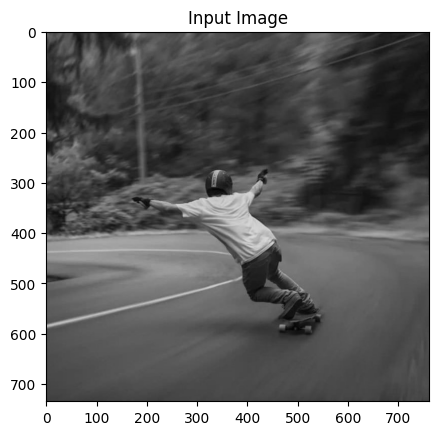

The input image is blurry.


In [49]:
# Load the input image
input_image_path = '/content/motion-blur.jpg'
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
#resized_image = cv2.resize(input_image, (256, 256))
input_image_gpu = cp.asarray(input_image)

# Detect blur using the GPU-accelerated FFT function
blur_score = detect_blur_fft_gpu(input_image_gpu)

# Reshape the feature for prediction
input_feature = blur_score.reshape(1, -1)

# Convert Cupy array to NumPy array
input_feature_numpy = input_feature.get()

# Make the prediction using the trained model
prediction = P.predict(input_feature_numpy)

# Display the image
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()

# Print the result
if prediction == 0:
    print("The input image is blurry.")
else:
    print("The input image is not blurry.")
